In [12]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
os.listdir("./pickle")

['train_pickle.pickle', 'test_pickle.pickle']

In [3]:
def get_dataset_labels(filename):
    def get_pickle(filename):
        with open(filename, "rb") as file:
            return pickle.load(file)
    pickles = get_pickle(filename)
    return pickles['dataset'], pickles['labels']
    
train_dataset, train_labels = get_dataset_labels("./pickle/train_pickle.pickle")
test_dataset,  test_labels  = get_dataset_labels("./pickle/test_pickle.pickle")
print("train dataset shape : ", train_dataset.shape)
print("train_labels.shape : ", train_labels.shape)

train dataset shape :  (33402, 64, 64)
train_labels.shape :  (33402,)


In [4]:
num_digits = 5
def get_max_digits(dataset, labels):
    keep = [i for i, label in enumerate(labels) if len(label) <= num_digits]
    return dataset[keep], labels[keep]

train_dataset, train_labels = get_max_digits( train_dataset, train_labels)
test_dataset,  test_labels  = get_max_digits( test_dataset, test_labels)

In [5]:
def show_shape(dataset, labels, data_type):
    print( data_type, " dataset shape : ", dataset.shape)
    print( data_type, " labels shape : ", labels.shape)

In [6]:
valid_size = int(train_dataset.shape[0] * 0.2)
valid_dataset = train_dataset[:valid_size]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:]
train_labels = train_labels[valid_size:]
show_shape( valid_dataset, valid_labels, "valid")
show_shape( train_dataset, train_labels, "train")
show_shape( test_dataset, test_labels, "test")

valid  dataset shape :  (6680, 64, 64)
valid  labels shape :  (6680,)
train  dataset shape :  (26721, 64, 64)
train  labels shape :  (26721,)
test  dataset shape :  (13068, 64, 64)
test  labels shape :  (13068,)


In [ ]:
np.append?

In [7]:
num_labels = 11
num_channels = 1

def reformat(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([ np.array([ ( np.arange(num_labels) == l).astype(np.float32)
                                        for l in np.append(row, [num_labels - 1] * (num_digits - len(row)), 0)])
                             for row in labels])
    return dataset_output, labels_output

In [8]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat( valid_dataset, valid_labels)
test_dataset, test_labels   = reformat( test_dataset, test_labels)
show_shape( train_dataset, train_labels, "train")
show_shape( valid_dataset, valid_labels, "valid")
show_shape( test_dataset, test_labels, "test")

train  dataset shape :  (26721, 64, 64, 1)
train  labels shape :  (26721, 5, 11)
valid  dataset shape :  (6680, 64, 64, 1)
valid  labels shape :  (6680, 5, 11)
test  dataset shape :  (13068, 64, 64, 1)
test  labels shape :  (13068, 5, 11)


Label :  [[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


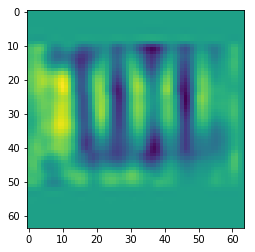

Label :  [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


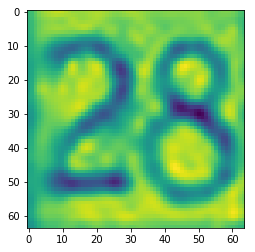

Label :  [[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


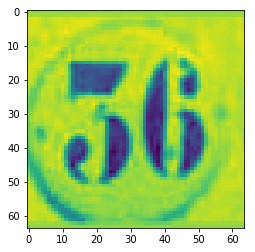

In [16]:
def show_image(img):
    img = img.reshape(img.shape[:2])
    plt.imshow(img)
    plt.show()

def show_images(dataset, labels, all_index):
    for index in all_index:
        print("Label : ", labels[index])
        show_image(dataset[index])        
rand_index = np.random.randint(0, train_dataset.shape[0], 3)
show_images( train_dataset, train_labels, rand_index)

array([11725, 13846])